In [1]:
data = read.table('SuppTable2_PolypALL_merged.txt', header = 1, stringsAsFactors = FALSE, row.names = 1)
data[1:10,1:10]

,Polyp1TOT_1,Polyp1TOT_2,Polyp1TOT_3,Polyp1TOT_4,Polyp1TOT_5,Polyp1TOT_6,Polyp1TOT_7,Polyp1TOT_8,Polyp1TOT_9,Polyp1TOT_10
A1BG,0,0,0,0,0,0,0,0,0,0
A1BG-AS1,0,0,0,0,0,0,0,0,0,0
A1CF,0,0,0,0,0,0,0,0,0,0
A2M,14,0,0,0,0,1,0,1,0,0
A2M-AS1,0,0,0,0,0,0,0,0,0,0
A2ML1,0,0,0,0,0,0,0,0,0,0
A4GALT,0,2,0,1,1,0,1,0,1,0
AAAS,0,0,0,0,0,0,0,0,2,1
AACS,0,0,0,0,0,0,0,1,0,0
AADAC,0,0,0,0,0,0,2,0,0,0


In [2]:
source("../../functions.R")

Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.5.3"Loading required package: cowplot
Warning message:
"package 'cowplot' was built under R version 3.5.3"
********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************

Loading required package: Matrix
Warning message:
"package 'feather' was built under R version 3.5.3"Warning message:
"package 'dplyr' was built under R version 3.5.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: viridisLite
Warning message:
"package 'tidyr' was built under R version 3.5.3"
Attaching package: 'tidyr'

The following object

In [4]:
seurat = CreateSeuratObject(data, min.genes = 500, min.cells = 3)
seurat

An object of class seurat in project SeuratProject 
 24352 genes across 14071 samples.

Regressing out: n_genes



Time Elapsed:  58.7989809513092 secs

Scaling data matrix


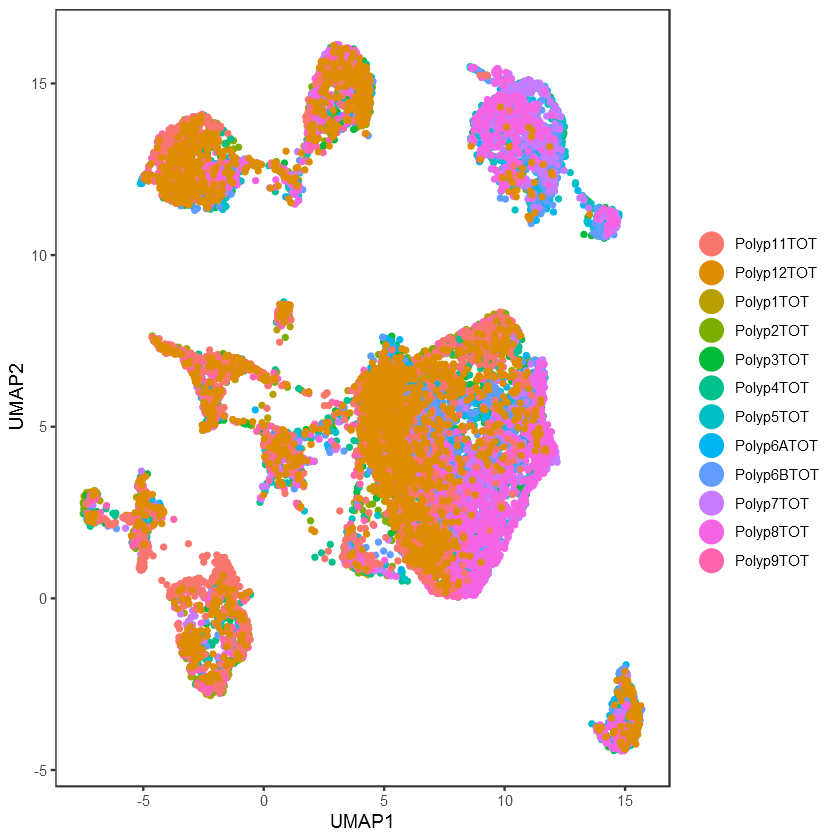

In [5]:
seurat@meta.data$n_genes = seurat@meta.data$nGene
seurat = seuratProcess(seurat)
DimPlot(seurat, 'umap')

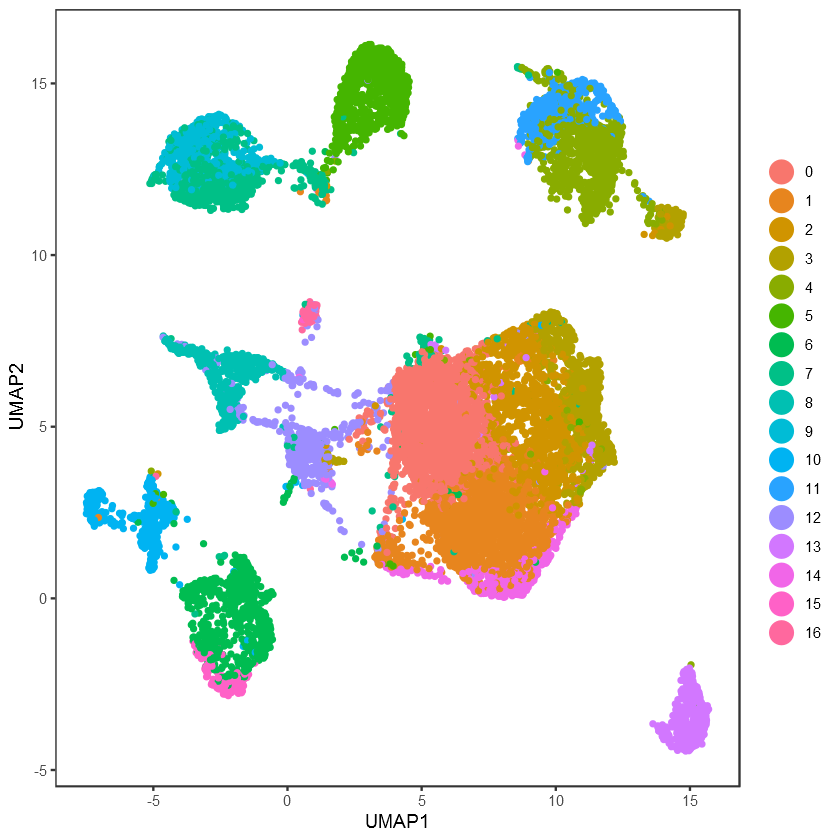

In [6]:
seurat = FindClusters(seurat, dims.use = 1:10, resolution = .8, print.output = FALSE)
DimPlot(seurat, 'umap')

Regressing out: n_genes



Time Elapsed:  20.9214460849762 secs

Scaling data matrix


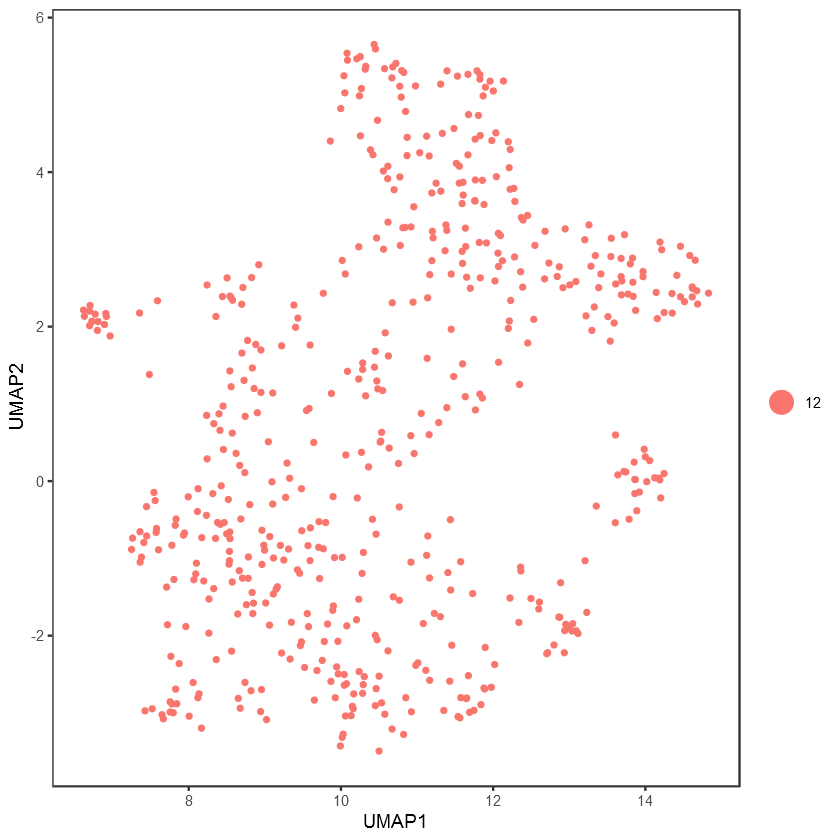

In [7]:
tcells = SubsetData(seurat, WhichCells(seurat, 12))
tcells = seuratProcess(tcells)
DimPlot(tcells, 'umap')

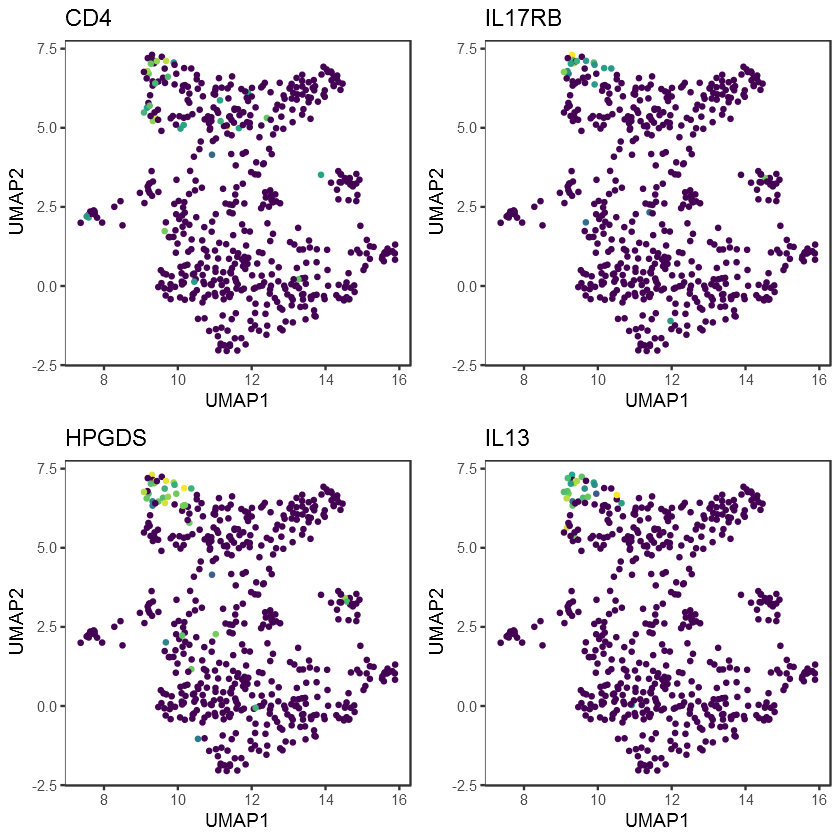

In [24]:
tcells = addUMAP(tcells)
geneplot(tcells, c("CD4", 'IL17RB', 'HPGDS', 'IL13'))

Warning message in FindClusters(tcells, dims.use = 1:10, resolution = 1.4, print.output = FALSE):
"Clustering parameters for resolution 1.4 exactly match those of already computed. 
  To force recalculation, set force.recalc to TRUE."

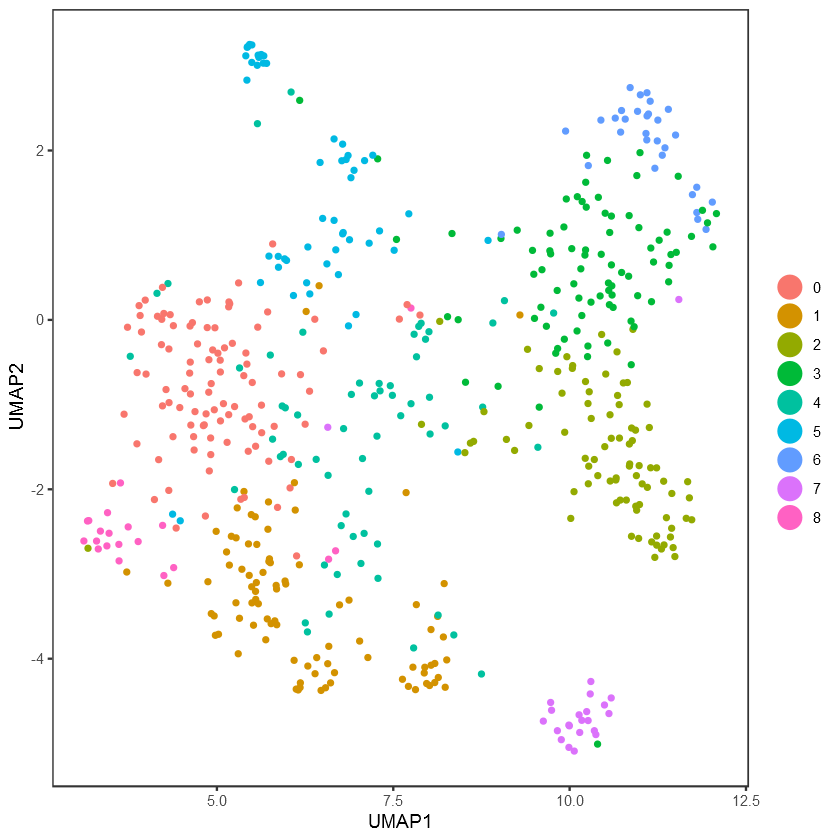

In [33]:
tcells = FindClusters(tcells, dims.use = 1:10, resolution = 1.4, print.output = FALSE)
DimPlot(tcells, 'umap')

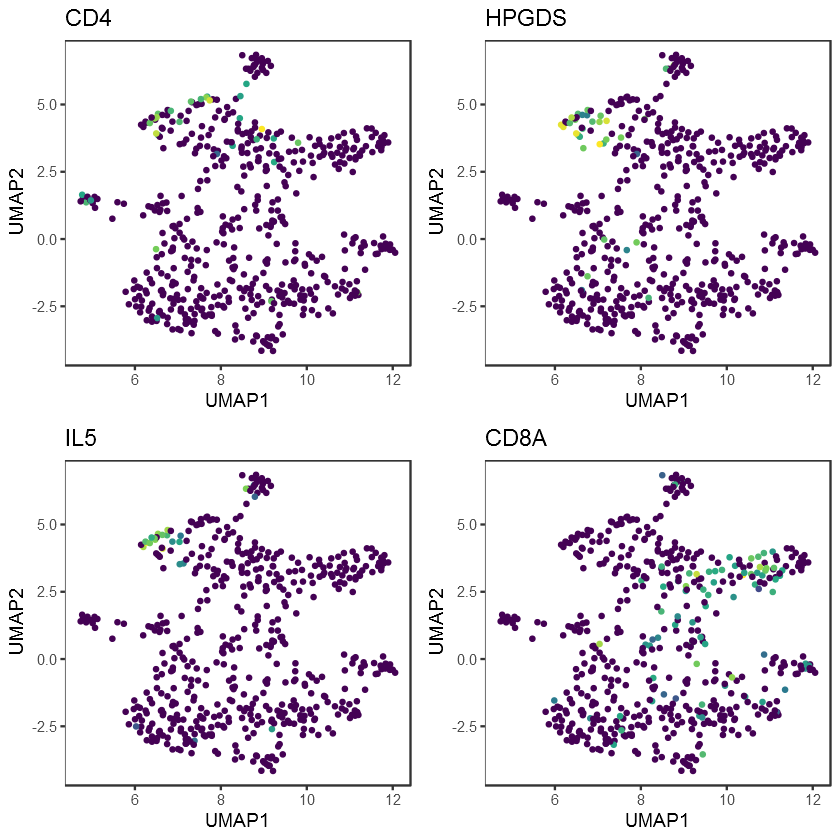

In [10]:
geneplot(tcells, c("CD4", 'HPGDS', 'IL5', 'CD8A'))

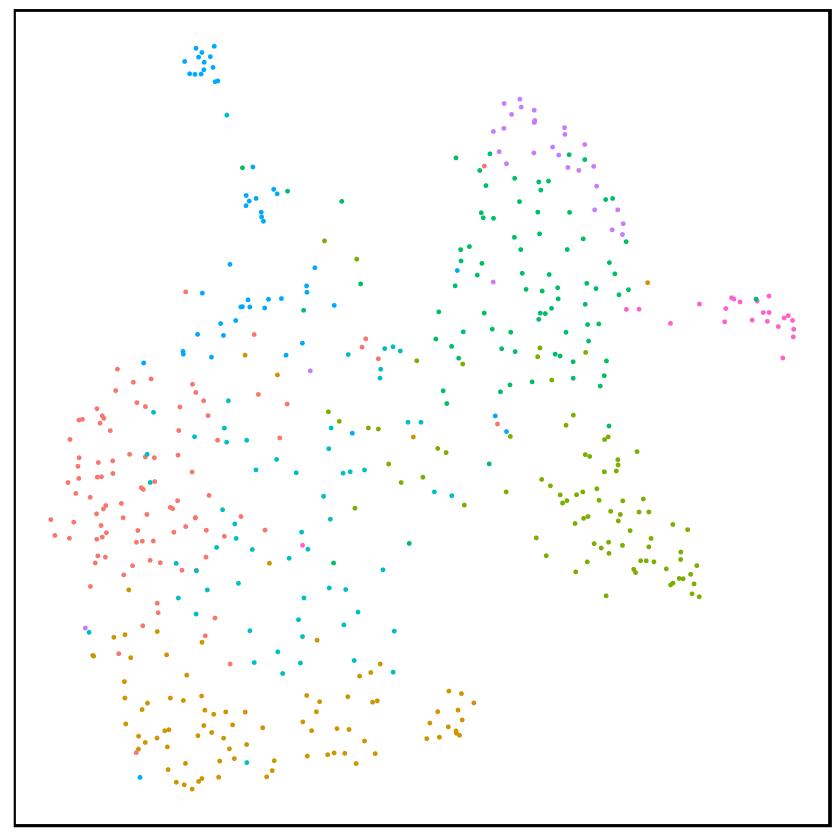

In [39]:
tcells = RunUMAP(tcells, dims.use = 1:20)
tcells= addUMAP(tcells)

ggplot(tcells@meta.data, aes(x = UMAP1, y = UMAP2, color = res.1.4)) + geom_point(size = 0.3) + UMAP_theme
ggsave('ordovas_umap.pdf', height = 2, width = 2, useDingbats = FALSE)

In [36]:
# remove cluster that contains eosinophils
tcells = SubsetData(tcells, tcells@cell.names[tcells@ident != 8])
tcells = seuratProcess(tcells)

Regressing out: n_genes



Time Elapsed:  20.1351900100708 secs

Scaling data matrix


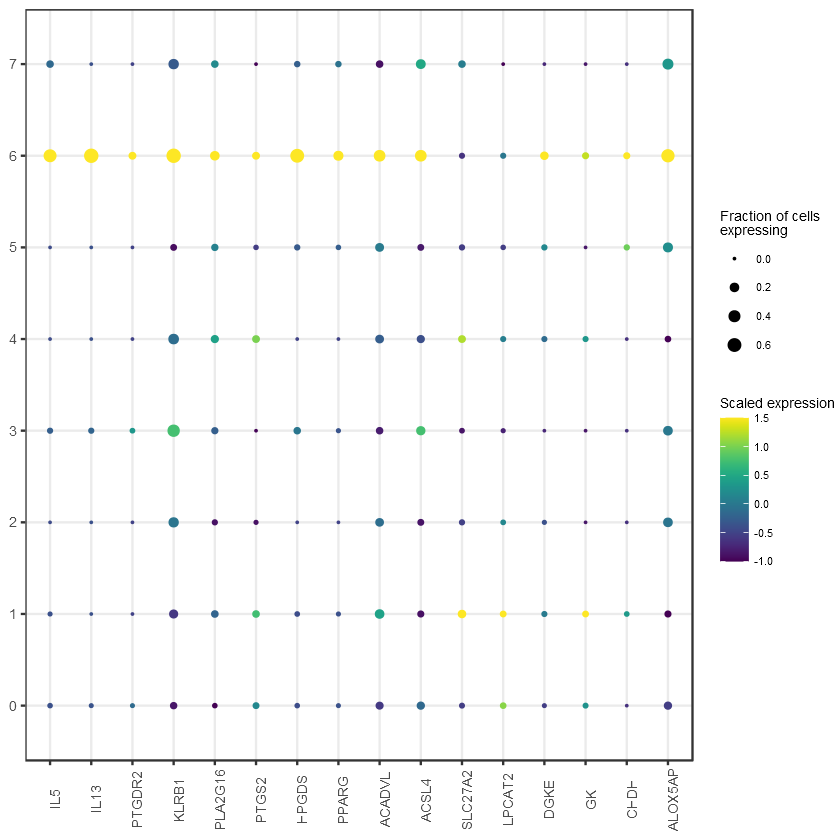

In [38]:
genes = c('IL5', 'IL13', 'PTGDR2', 'KLRB1','PLA2G16', 'PTGS2',  'HPGDS','PPARG','ACADVL', 'ACSL4','SLC27A2', 'LPCAT2','DGKE', 'GK','CHDH', 'ALOX5AP')
# Panel 3: phenotype of eosinophils and neutrophils
pct = function(x) {
  sum(x >0)/length(x)
}
meanexp = function(x) {
    mean(x)
}

data = as.data.frame(t(as.matrix(tcells@data[genes,])))
data$phenotype = tcells@meta.data$res.1.4
df_exp = data %>% group_by(phenotype) %>% summarize_all(.funs = list(meanexp)) %>% as.data.frame() 
keep = df_exp
df_exp[,2:(1+length(genes))] = scale(df_exp[,2:(1+length(genes))])
df_exp = df_exp %>% melt(id.vars = 'phenotype')
df_pct = data %>% group_by(phenotype) %>% summarize_all(.funs = list(pct)) %>% melt(id.vars = 'phenotype')
df_exp$value[df_exp$value > 1.5] = 1.5
df_exp$value[df_exp$value < -1]= -1
df_exp$pct = df_pct$value
df_exp$value = as.vector(df_exp$value)
#df_exp$value[is.nan(df_exp$value)] = 0

ggplot(as.data.frame(df_exp), aes(y = phenotype, x = variable, size = pct, color = value)) + geom_point() + scale_color_viridis()  + 

 theme_bw()  + theme(axis.title = element_blank(), axis.text.x = element_text(angle = 90)) + 
labs(color = "Scaled expression", size = 'Fraction of cells\nexpressing') + scale_x_discrete(limits = genes) + Axis_themes + 
theme(axis.title = element_blank(), axis.text.x = element_text(size = 8), axis.text.y = element_text(size = 8))+ 
 scale_size_continuous(range = c(0, 3))
#ggsave('peth2markers.pdf', height = 3, width = 4.5, useDingbats = FALSE)
#ggsave('peth2markers.eps', height = 3, width = 5)
ggsave('ordovas_dots.pdf', height = 3.2, width = 3.5, useDingbats = FALSE)